### Import required libraries

In [7]:
from transformers import (
    BartForConditionalGeneration,
    BartTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback
)
from datasets import load_from_disk, load_metric
import torch
import pandas as pd
import matplotlib.pyplot as plt

### Load the pre-trained BART model and tokenizer

In [127]:
# model = BartForConditionalGeneration.from_pretrained('lucadiliello/bart-small')
# tokenizer = BartTokenizer.from_pretrained('lucadiliello/bart-small')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

In [220]:
folder_path = '../../../data/seq2seq'
# Load the dataset from disk
seq2seq_dataset = load_from_disk(folder_path)

In [221]:
# Select a larger subset of the dataset if possible
train_dataset = seq2seq_dataset['train']
eval_dataset = seq2seq_dataset['dev']
test_dataset = seq2seq_dataset['test']

### Preprocess data for BART model

In [222]:
max_source_length = 1024
max_target_length = 128

def preprocess_function(examples):
    return {
        'input_ids': tokenizer(examples['source'],
                               truncation=True,
                               padding='max_length',
                               max_length=max_source_length,
                               return_tensors="pt")['input_ids'],
        'labels': tokenizer(examples['target'],
                            truncation=True,
                            padding='max_length',
                            max_length=max_target_length,
                            return_tensors="pt")['input_ids'],
    }
    
train_dataset = train_dataset.map(preprocess_function, batched=True)
eval_dataset = eval_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/51961 [00:00<?, ? examples/s]

Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/963 [00:00<?, ? examples/s]

### Model Training

In [6]:
# Define the training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir='../../../results/bart-base',
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    fp16=True,
    save_total_limit=3,
    predict_with_generate=True,
    # warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
)

The `TrainingArguments` are used to define the training parameters for fine-tuning the BART model. Here's a more detailed explanation of these parameters:

1. `num_train_epochs`: The number of epochs is the number of times the entire dataset is passed forward and backward through the neural network. Too few epochs can result in underfitting of the model, while too many epochs can result in overfitting. For fine-tuning tasks, a small number of epochs (2-4) is often sufficient.

2. `per_device_train_batch_size` and `per_device_eval_batch_size`: The batch size is the number of training examples used in one iteration. Smaller batch sizes can lead to a more stable convergence, and they also provide a regularizing effect, helping to prevent overfitting.

3. `gradient_accumulation_steps`: This parameter is used when we want to update the model weights less frequently than after each batch. This can be useful when GPU memory is limited. It effectively increases the batch size and can lead to better model performance.

4. `fp16`: This enables mixed-precision training, which can speed up the training process and reduce memory usage without a significant loss in model performance. It does this by using a mix of float16 and float32 for different parts of the model.

5. `save_total_limit`: This parameter is used to limit the total amount of checkpoints that can be saved on disk. During training, the model's weights are saved at regular intervals to allow for resuming training if it's interrupted, and for model selection after training. For limited disk space or if training a large model for many epochs, the number of checkpoints can become quite large. By setting `save_total_limit`, it can be ensured that only the most recent checkpoints are saved and older ones are deleted.

6. `predict_with_generate`: This is crucial for text generation tasks. It ensures that the model's `generate` function is used during prediction, which is necessary for generating coherent text.

7. `weight_decay`: This adds a regularization term to the loss function, which can help to prevent overfitting. It does this by adding a penalty to large weights, encouraging the model to use smaller weights and thus reducing the complexity of the model.

7. `learning_rate`: This controls the step size during optimization. A smaller learning rate means the model learns more slowly, which can lead to more stable training and better final performance. However, it also means that training will take longer.

8. `evaluation_strategy`: This parameter determines when evaluation is performed during training. There are three options: "no", "steps", and "epoch". If "no", evaluation is not performed during training. If "steps", evaluation is performed after a certain number of steps, as defined by `eval_steps`. If "epoch", evaluation is performed after each epoch. 

8. `load_best_model_at_end`: This ensures that the model with the best performance on the validation set is loaded at the end of training. This is useful if the model's performance starts to decrease due to overfitting in later epochs.

In [7]:
# Load the checkpoint
model = BartForConditionalGeneration.from_pretrained("../../../results/bart-base/checkpoint-3000")

# Fine-tune the BART model
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

/common/home/st1122/.cache/pypoetry/virtualenvs/debiasing-text-with-style-transfer-XprOT1eT-py3.10/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
500,0.004500,0.006106
1000,0.003600,0.005706
1500,0.003100,0.006132
2000,0.003200,0.006123
2500,0.003000,0.006137


/common/home/st1122/.cache/pypoetry/virtualenvs/debiasing-text-with-style-transfer-XprOT1eT-py3.10/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/common/home/st1122/.cache/pypoetry/virtualenvs/debiasing-text-with-style-transfer-XprOT1eT-py3.10/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/common/home/st1122/.cache/pypoetry/virtualenvs/debiasing-text-with-style-transfer-XprOT1eT-py3.10/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze a

TrainOutput(global_step=2500, training_loss=0.003463900327682495, metrics={'train_runtime': 3181.099, 'train_samples_per_second': 32.669, 'train_steps_per_second': 4.083, 'total_flos': 1.21947291648e+16, 'train_loss': 0.003463900327682495, 'epoch': 0.38})

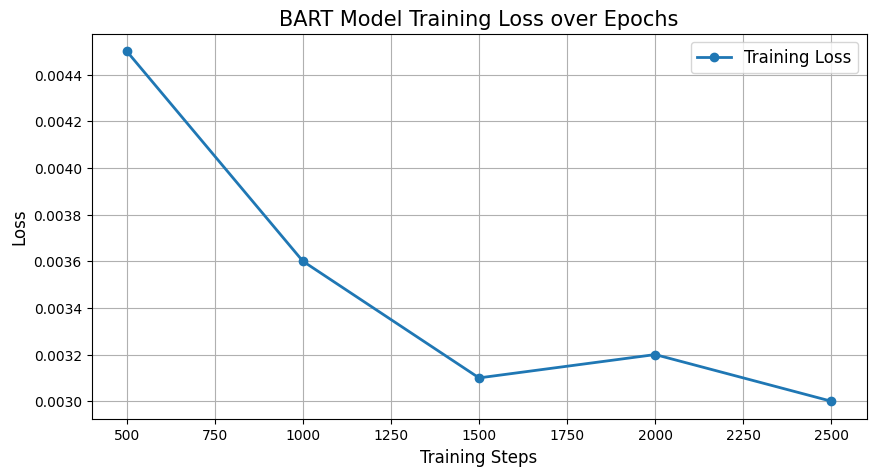

In [5]:
# Training steps
steps = [500, 1000, 1500, 2000, 2500]

# Training and validation loss values
training_loss = [0.004500, 0.003600, 0.003100, 0.003200, 0.003000]

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 5))

# Plot training loss
ax.plot(steps, training_loss, label='Training Loss', marker='o', linestyle='-', linewidth=2)

# Set title and labels
ax.set_title('BART Model Training Loss over Epochs', fontsize=15)
ax.set_xlabel('Training Steps', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

# Set grid
ax.grid(True)

# Set legend
ax.legend(fontsize=12)

# Save the plot
plt.savefig('../../plots/bart_training_loss.png')

# Show the plot
plt.show()

In [8]:
# Save the fine-tuned BART model
model_path = "../../../models/bart-base"

# Save the fine-tuned BART model
model.save_pretrained(model_path)

### Model Evaluation

In [75]:
# Evaluate the model
evaluation_results = trainer.evaluate()

print(evaluation_results)

{'eval_loss': 0.005706394091248512, 'eval_runtime': 36.4941, 'eval_samples_per_second': 18.414, 'eval_steps_per_second': 4.603, 'epoch': 0.38}


In [162]:
small_test_dataset = seq2seq_dataset['test'].select(range(10))
small_test_dataset = small_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [167]:
def generate_text_batch(examples_batch: dict):
    # Ensure the model inputs are on the same device as the model
    input_ids = torch.tensor(examples_batch["input_ids"]).to(model.device)

    # Generate the output sequence
    generated_ids = model.generate(
        input_ids=input_ids,
        max_length=max_target_length,
        num_beams=4,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    # Decode the generated ids to get the predicted text
    predicted_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

    return predicted_texts

In [168]:
preds = generate_text_batch(small_test_dataset)
preds

['in april 2009 a brazilian human rights group, torture never again, awarded the five its chico mendes medal, because their rights had been violated.',
 'the 51 day standoff and ensuing murder of 76 men, women, and children--the branch davidians--in waco, texas.',
 'mark oaten (born 8 march 1964, watford) is a liberal democrat politician in the united kingdom, and member of parliament for the winchester constituency.',
 'another period of colonisation in ancient times was from the romans.',
 'photo sequence of 2005 chicagoland crash with ryan briscoe.',
 'jesus of nazareth is mentioned in two passages of the work the antiquities of the jews by the jewish historian josephus, written in the late first century ad.',
 'israeli attempts to reduce gazan civilian casualties',
 'his 45-year career exceeded that of any other studio head.',
 'they see the calling of such councils, for example, by a roman emperor lacking the divine authority as preposterous and assert that the emperors used the c

In [169]:
labels = small_test_dataset["target"]
labels

['in april 2009 a brazilian human rights group, torture never again, awarded the five its chico mendes medal, under the pretext that their rights had been violated.',
 'the 51 day standoff and ensuing deaths of 76 men, women, and children--the branch davidians--in waco, texas.',
 'mark oaten (born 8 march 1964, watford) is a liberal democrat politician in the united kingdom, and member of parliament for the winchester constituency.',
 'another period of colonisation in ancient times was from the romans.',
 'photo sequence of 2005 chicagoland crash with ryan briscoe.',
 'jesus of nazareth is possibly mentioned in two passages of the work the antiquities of the jews by the jewish historian josephus, written in the late first century ad.',
 'israeli efforts to reduce gazan civilian casualties',
 'his 45-year career was longer than that of any other studio head.',
 'they see the calling of such councils, for example, by a roman emperor lacking the divine authority as groundless and assert 

In [170]:
metric = load_metric("rouge")
result = metric.compute(predictions=preds, references=labels, use_stemmer=True)
result

{'rouge1': AggregateScore(low=Score(precision=0.9293696884256096, recall=0.8861577998193241, fmeasure=0.9096871137118814), mid=Score(precision=0.9603071489913595, recall=0.9379602853287065, fmeasure=0.947777815579673), high=Score(precision=0.9839775641025641, recall=0.9774598798056149, fmeasure=0.9780226868075166)),
 'rouge2': AggregateScore(low=Score(precision=0.8429874989405882, recall=0.8062719298245616, fmeasure=0.8258288555130662), mid=Score(precision=0.9083786761589965, recall=0.8855182828867039, fmeasure=0.8951918288760394), high=Score(precision=0.964139333841851, recall=0.9585292558318874, fmeasure=0.9589570168254379)),
 'rougeL': AggregateScore(low=Score(precision=0.9291115857826384, recall=0.8871490914140642, fmeasure=0.9102543689540594), mid=Score(precision=0.9607259407259405, recall=0.9392128641674922, fmeasure=0.9487173816895179), high=Score(precision=0.9854419703103915, recall=0.98005698005698, fmeasure=0.9814020628494313)),
 'rougeLsum': AggregateScore(low=Score(precisio

In [171]:
{key: value.mid.fmeasure * 100 for key, value in result.items()}

{'rouge1': 94.7777815579673,
 'rouge2': 89.51918288760395,
 'rougeL': 94.8717381689518,
 'rougeLsum': 94.78835663820185}

In [207]:
for i, (source, target, pred) in enumerate(zip(small_test_dataset["source"], labels, preds)):
    output = f"\nEXAMPLE {i+1}\n{'-' * 100}\n"
    output += f"{'Source':<10}: {source}\n"
    output += f"{'Target':<10}: {target}\n"
    output += f"{'Predicted':<10}: {pred}\n"
    
    # Split the source and predicted text into words
    source_words = set(source.split())
    pred_words = set(pred.split())

    # Compute the added and removed words
    added = pred_words - source_words
    removed = source_words - pred_words

    # Check if there are any changes
    if not added and not removed:
        output += f"{'CHANGE':<10}: {'No change'}\n"
    else:
        if added:
            output += f"{'ADDED':<10}: {', '.join(added)}\n"
        if removed:
            output += f"{'REMOVED':<10}: {', '.join(removed)}\n"
    output += f"{'-' * 100}"
    print(output)


EXAMPLE 1
----------------------------------------------------------------------------------------------------
Source    : in april 2009 a brazilian human rights group, torture never again, awarded the five its chico mendes medal, because their rights had been violated.
Target    : in april 2009 a brazilian human rights group, torture never again, awarded the five its chico mendes medal, under the pretext that their rights had been violated.
Predicted : in april 2009 a brazilian human rights group, torture never again, awarded the five its chico mendes medal, because their rights had been violated.
CHANGE    : No change
----------------------------------------------------------------------------------------------------

EXAMPLE 2
----------------------------------------------------------------------------------------------------
Source    : the 51 day standoff and ensuing murder of 76 men, women, and children--the branch davidians--in waco, texas.
Target    : the 51 day standoff and e

In [213]:
saved_model = BartForConditionalGeneration.from_pretrained("../../../models/bart-base")

### Test model on full test set

In [224]:
# Generate predictions for the complete test dataset
predictions = []
for batch in test_dataset:
    inputs = torch.tensor(batch['input_ids']).unsqueeze(0).to(saved_model.device)
    summary_ids = saved_model.generate(inputs, num_beams=4, max_length=max_target_length, early_stopping=True)
    predictions.extend([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

In [225]:
# Create a DataFrame and save predictions to CSV
df = pd.DataFrame({
    'predictions': predictions
})
df.to_csv('../../data/bart_predictions.csv', index=False)